In [68]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interact_manual


First, we will import and sanitize our datasets, starting with the COVID data from Johns Hopkins.

Let's user the head() function to see what our data looks like:

In [69]:
dfCOVID = pd.read_csv('johnshopkins.csv')
dfCOVID.head()


,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,3233,3258,3300,3329,3426,3510,3570,3647,3698,3741
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,10489,10665,10806,10898,11061,11212,11364,11556,11722,11827
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,1264,1269,1272,1275,1292,1296,1309,1318,1330,1336
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,1398,1417,1441,1455,1504,1520,1548,1577,1601,1613
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,3663,3744,3776,3803,3881,3950,4036,4118,4191,4218


The imported COVID dataset has several columns that are not useful for the scope of this project. Let's drop those.

In [70]:
to_drop = ['iso2',
           'iso3',
           'code3',
           'FIPS',
           'Country_Region',
           'Admin2',
           'Province_State',
           'Combined_Key',
           'Lat',
           'Long_']

dfCOVID.drop(to_drop, inplace=True, axis=1)
dfCOVID = dfCOVID.set_index('UID')
dfCOVID.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20
UID,,,,,,,,,,,,,,,,,,,,,
84001001,0,0,0,0,0,0,0,0,0,0,...,3233,3258,3300,3329,3426,3510,3570,3647,3698,3741
84001003,0,0,0,0,0,0,0,0,0,0,...,10489,10665,10806,10898,11061,11212,11364,11556,11722,11827
84001005,0,0,0,0,0,0,0,0,0,0,...,1264,1269,1272,1275,1292,1296,1309,1318,1330,1336
84001007,0,0,0,0,0,0,0,0,0,0,...,1398,1417,1441,1455,1504,1520,1548,1577,1601,1613
84001009,0,0,0,0,0,0,0,0,0,0,...,3663,3744,3776,3803,3881,3950,4036,4118,4191,4218


Now we're left with a unique identifier for each county and its case count by day. Just what we need!

We've also set the UID as the index for our dataframe.

Next, let's make sure our columns' datatypes are set up appropriately. We'll leave the string columns as they are,
but we'll need to make sure each of the case count columns is stored numerically.



In [71]:
for col in dfCOVID.filter(like='1').columns:
    dfCOVID[col] = pd.to_numeric(dfCOVID[col], errors='coerce')

Next, create a new dataframe indicating the daily total case count. This will give
us a more lightweight dataframe to work with for our analysis.

In [72]:
dfCOVIDtotal = pd.DataFrame(dfCOVID.sum(),
                            columns = ['Cases'])
dfCOVIDtotal.index = pd.to_datetime(dfCOVIDtotal.index)
print(dfCOVIDtotal.index.dtype)
dfCOVIDtotal.head()

datetime64[ns]


,Cases
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,2
2020-01-26,5


That should do it for the COVID set - the Johns Hopkins data is managed by a highly qualified team, so let's avoid skewing the data
by unnecessarily altering it. Next is the client's staffing data!

Next, we'll read in N7 Staffing's data from 2020. We'll use head() again here to get an idea of what
we're working with.

In [73]:
dfN7 = pd.read_csv('N7data.csv')
dfN7.head()

,employeeID,clientCompany,clientIndustry,startDate,endDate,jobTitle,payrate,markup,billrate,hours
0,1776,Corwin LLC,NaN,10/18/2020,10/18/2020,Account Executive,13.03,39,18.11,1.199923
1,1253,"Breitenberg, Rogahn and Abbott",Real Estate,4/7/2020,4/7/2020,Research Associate,23.28,34,31.20,1.381912
2,1865,Jast Group,NaN,11/18/2020,11/18/2020,Dental Hygienist,10.54,29,13.60,1.452889
3,1065,Mann-Kihn,Major Banks,1/24/2020,1/24/2020,Executive Secretary,16.46,36,22.39,1.674138
4,1880,Conroy-Beer,Major Chemicals,11/25/2020,11/25/2020,Geologist II,12.29,22,14.99,2.265136


Let's drop the columns we don't need and set employeeID as our index.


In [74]:
to_drop = ['clientCompany',
           'clientIndustry',
           'jobTitle']

dfN7.drop(to_drop, inplace=True, axis=1)
dfN7 = dfN7.set_index('employeeID')

Just like our COVID set, we'll make sure numerical data is stored as an appropriate datatype.

In [75]:
dfN7['startDate'] = pd.to_datetime(dfN7['startDate'], format='%m/%d/%Y')
dfN7['endDate'] = pd.to_datetime(dfN7['endDate'], format='%m/%d/%Y')
dfN7['payrate'] = pd.to_numeric(dfN7['payrate'])
dfN7['markup'] = pd.to_numeric(dfN7['markup'])
dfN7['billrate'] = pd.to_numeric(dfN7['billrate'])
dfN7['hours'] = pd.to_numeric(dfN7['hours'])

Let's write a function to filter our COVID cases by date range.

In [ ]:
def find_cases_in_date_range(start_date, end_date):
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    dfCasesInDateRange = dfCOVIDtotal.loc[(dfCOVIDtotal.index >= start_date) & (dfCOVIDtotal.index <= end_date)].copy()
    total_cases = dfCasesInDateRange['Cases'].sum()
    print(f'There were {total_cases} COVID cases between {start_date.date()} and {end_date.date()}.')
    return

_ = interact(find_cases_in_date_range,
             start_date=widgets.DatePicker(value=pd.to_datetime('2020-01-01'), description="Start Date", disabled=False),
             end_date=widgets.DatePicker(value=pd.to_datetime('2020-12-25'), description="End Date", disabled=False))

interactive(children=(DatePicker(value=Timestamp('2020-01-01 00:00:00'), description='Start Date'), DatePicker…

We will write another function to filter N7's data by date as well. We'll look for all placements 
that are active on a given date.

In [77]:
def find_placements_active_on_date(date_input):
    date = pd.Timestamp(date_input)
    dfActivePlacementsByDate = dfN7.loc[(dfN7.startDate <= date) & (dfN7.endDate >= date)].copy()
    date_placements = dfActivePlacementsByDate.count()
    return date_placements.startDate

Let's create another dataframe with a count of all COVID cases and active placements on a given date.

In [78]:
dfCOVIDtotal['Active Placements'] = [find_placements_active_on_date(x) for x in dfCOVIDtotal.index]
dfCOVIDtotal.head()


,Cases,Active Placements
2020-01-22,1,57
2020-01-23,1,60
2020-01-24,2,61
2020-01-25,2,63
2020-01-26,5,69


Next, we'll write the function to filter our new dataframe for a date range. This will be used on
our visualizations to allow us to view varying spans of the data.

In [79]:
def date_filter(start_date, end_date):
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    global dfFilterResults
    dfFilterResults = dfCOVIDtotal.loc[(dfCOVIDtotal.index >= start_date) & (dfCOVIDtotal.index <= end_date)].copy()
    return dfFilterResults

_ = interact(date_filter,
             start_date=widgets.DatePicker(value=pd.to_datetime('2020-01-01'), description="Start Date", disabled=False),
             end_date=widgets.DatePicker(value=pd.to_datetime('2020-12-25'), description="End Date", disabled=False))

interactive(children=(DatePicker(value=Timestamp('2020-01-01 00:00:00'), description='Start Date'), DatePicker…

Next, let's plot our case count and placement count by day.



In [80]:
def scatterplot(start_date, end_date):
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    dfDataInDateRange = dfCOVIDtotal.loc[(dfCOVIDtotal.index >= start_date) & (dfCOVIDtotal.index <= end_date)].copy()

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(dfDataInDateRange.index, dfDataInDateRange['Active Placements'])
    ax1.set_ylabel('Placements')

    ax2 = ax1.twinx()
    ax2.plot(dfDataInDateRange.index, dfDataInDateRange['Cases'], 'r-')
    ax2.set_ylabel('Cases', color='r')
    for t1 in ax2.get_yticklabels():
        t1.set_color('r')

    plt.ticklabel_format(axis='y', style = 'plain')
    plt.title('COVID Cases vs Active Placements by Date')
    plt.show()
    return

_ = interact(scatterplot,
             start_date=widgets.DatePicker(value=pd.to_datetime('2020-01-01'), description="Start Date", disabled=False),
             end_date=widgets.DatePicker(value=pd.to_datetime('2020-12-25'), description="End Date", disabled=False))


interactive(children=(DatePicker(value=Timestamp('2020-01-01 00:00:00'), description='Start Date'), DatePicker…

It's evident that our placement data has a lag effect - since it only includes placements that started in 
2020, any employees placed in 2019 but still working in 2020 aren't reflected - try adjusting the start date
filter to mid-march to get a less skewed view.

It appears our placement count doesn't correlate too closely with COVID case totals. Let's try viewing the data
in a few different ways to take a closer look. We'll start with K-Means clustering. This descriptive method is great for
trying to group data into similar clusters to find patterns.

In [81]:
def kmeansplot(start_date, end_date):
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    dfDataInDateRange = dfCOVIDtotal.loc[(dfCOVIDtotal.index >= start_date) & (dfCOVIDtotal.index <= end_date)].copy()
    kmeans = KMeans (n_clusters=6).fit(dfDataInDateRange)
    centroids = kmeans.cluster_centers_

    plt.scatter(dfDataInDateRange['Cases'], dfDataInDateRange['Active Placements'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red')
    plt.title('K-Means Clustering of Active Placements by COVID Cases')
    plt.xlabel('Covid Cases')
    plt.ylabel('Active Placements')
    plt.show()
    return 

_ = interact(kmeansplot,
             start_date=widgets.DatePicker(value=pd.to_datetime('2020-01-01'), description="Start Date", disabled=False),
             end_date=widgets.DatePicker(value=pd.to_datetime('2020-12-25'), description="End Date", disabled=False))

interactive(children=(DatePicker(value=Timestamp('2020-01-01 00:00:00'), description='Start Date'), DatePicker…

In the above K-Means cluster plot, it is clear that N7 was impacted by the initial lockdowns around the 
1-3 million case count range, but then quickly returned to pre-COVID levels as things reopened over the next months.
(The yellow and purple clusters, respectively).

Let's take a look at a simple linear regression plot and see what trends are visible.


In [82]:
def linearregressionplot(start_date, end_date):
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    dfDataInDateRange = dfCOVIDtotal.loc[(dfCOVIDtotal.index >= start_date) & (dfCOVIDtotal.index <= end_date)].copy()
    d = np.polyfit(dfDataInDateRange['Cases'], dfDataInDateRange['Active Placements'], 1)
    f = np.poly1d(d)
    dfDataInDateRange.insert(2,'Fit',f(dfDataInDateRange['Cases']))
    ax = dfDataInDateRange.plot(x='Cases', y='Active Placements')
    dfDataInDateRange.plot(x='Cases', y='Fit', color='Red', ax=ax, title='Linear Regression of Placements by Cases')

    return

_ = interact(linearregressionplot,
             start_date=widgets.DatePicker(value=pd.to_datetime('2020-01-01'), description="Start Date", disabled=False),
             end_date=widgets.DatePicker(value=pd.to_datetime('2020-12-25'), description="End Date", disabled=False))


interactive(children=(DatePicker(value=Timestamp('2020-01-01 00:00:00'), description='Start Date'), DatePicker…

A simple linear regression indicates a positive trajectory for N7, even when the lagging (pre mid-March) data is removed.

Let's see what a non-descriptive method can tell us through logistic regression. Logistic regression is a classification algorithm,
so first we'll need to add a column to our dataframe with binary data. Let's first find the average number of placements
for 2020 (ignoring the outliers for Jan/Feb) and add a column indicating whether each date's placement count is equal to or greater than average.

In [83]:
dfFiltered = date_filter('2020-03-15', '2020-12-25')
filteredMean = dfFiltered['Active Placements'].mean()
print(f'The mean active placements is {filteredMean}.')

def is_equal_or_above_mean (placements):
    if placements >= filteredMean:
        return 1
    if placements < filteredMean:
        return 0

dfFiltered['Is >= Mean'] = [is_equal_or_above_mean(x) for x in dfFiltered['Active Placements']]


The mean active placements is 151.38434163701066.




Next, we'll split our data.

70% Training, 30% Testing

In [84]:
from sklearn.model_selection import train_test_split

feature_col_names = ['Cases']
predicted_class_names = ['Is >= Mean']

X = dfFiltered[feature_col_names]
Y = dfFiltered[predicted_class_names]
split_test_size = 0.30

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=split_test_size, random_state=580)

print("{0:0.2f}% in training set".format((len(X_train)/len(dfFiltered.index)) * 100))
print("{0:0.2f}% in test set".format((len(X_test)/len(dfFiltered.index)) * 100))

69.75% in training set
30.25% in test set


Now that the date is split, let's train the model and test it's accuracy. 

In [85]:
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression(solver='lbfgs', class_weight='balanced')
LogReg.fit(X_train, y_train.values.ravel())
regression_predict = LogReg.predict(X_train)
LogReg.score(X_test, y_test)

from sklearn import metrics

y_pred=LogReg.predict(X_test)
metrics.accuracy_score(y_test, y_pred)


0.5882352941176471

The model performs with a 58% accuracy.

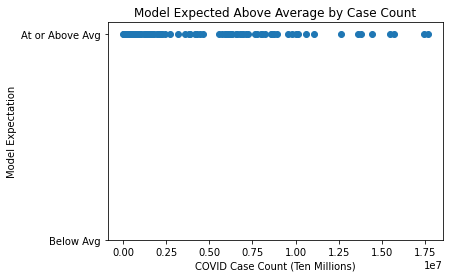

In [86]:


def plot_model_vs_test():

    ax2 = plt.scatter(X_test, LogReg.predict(X_test))
    plt.title('Model Expected Above Average by Case Count')
    plt.xlabel('COVID Case Count (Ten Millions)')
    plt.ylabel('Model Expectation')
    xlabels = ['Below Avg', 'At or Above Avg']
    plt.yticks(range(0, 2, 1), xlabels)
    plt.show(ax2)
    return

plot_model_vs_test()


The above plot makes it apparent that our model supports our previous plots - COVID has had little impact upon placement count at N7 Staffing. Regardless of case count, the overall trend supports at or above average placement volume.
